# IAU projekt

> Rovnakým podieľom práce vypracovali: <br>
> Roman Bitarovský, Emma Macháčová

## Table of contents <a name="obsah"></a>
* [Zadanie](#zadanie)
    * [Slovníček](#slovnicek)
   
* [Data init](#dataInit)
* [Fáza 2](#faza2)
* [Fáza 3](#faza3)
    * [3.1. Jednoduchý klasifikátor na základe závislosti v dátach](#3.1.)
    * [3.2. Trénovanie a vyhodnotenie klasifikátorov strojového učenia](#3.2.)  
        * [3.2.1 Decision tree](#3.2.1.)
        * [3.2.2 Random forest](#3.2.2.)
    * [3.3. Optimalizácia alias hyperparameter tuning](#3.3.)  
        * [3.3.1. GridSearch Cross Validation](#3.3.1.)
        * [3.3.2. RandomizedSearch Cross Validation](#3.3.2.)
    * [3.4. Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu](#3.4.)  
        * [Test 1](#t1)
        * [Test 2](#t2)
        * [Test 3](#t3)
        * [Test 4](#t4)
        * [Test 5](#t5)
        * [Test 6](#t6)

# Zadanie <a name="zadanie"></a>
Znečistenie ovzdušia spôsobuje vážne dýchacie a srdcové ochorenia, ktoré môžu byť smrteľné. Najčastejšie sú postihnuté deti, čo vedie k zápalu pľúc a problémom s dýchaním vrátane astmy. Kyslé dažde, ničenie ozónovej vrstvy a globálne otepľovanie sú niektoré z nepriaznivých dôsledkov. Dátová sada pre Vás (World's Air Pollution: Real-time Air Quality Index https://waqi.info/) predstavuje záznamy jednotlivých meraní kvality ovzdušia ako kombinácia mnohých faktorov bez časovej následnosti. V záznamoch je závislá premenná s menom “warning” indikujúca alarmujúci stav kvality ovzdušia. Vo veľkých mestách ako napr. Peking (angl. Beijing, hlavné mesto Číny s viac ako 21 miliónov ľudí) sa pri varovaní spustí opatrenie ako obmedzenie pohybov áut a ľudí v meste alebo umelý dážď až pokiaľ kvalita vzduchu sa nevráti do normu.

* Úlohou je predikovať závislé hodnoty premennej “warning” pomocou metód strojového učenia.
* Pritom sa treba vysporiadať s viacerými problémami, ktoré sa v dátach nachádzajú ako formáty dát, chýbajúce, vychýlené hodnoty a pod.

## Slovníček  <a name="slovnicek"></a>
<details>
    <summary>Zobraziť</summary>
    
    PM2.5 - Particulate Matter (µg/m3) 
    PM10 - Particulate Matter (µg/m3) 
    NOx - Nitrogen Oxides (µg/m3)
    NO2 - Nitrogen Dioxide (µg/m3)
    SO2 - Sulfur Dioxide  (µg/m3)
    CO - Carbon Monoxide emissions  (µg/m3)
    CO2 - Carbon Dioxide  (µg/m3)
    PAHs - Polycyclic Aromatic Hydrocarbons  (µg/m3)
    NH3 - Ammonia trace  (µg/m3)
    Pb - Lead  (µg/m3)
    TEMP - Temperature (degree Celsius)
    DEWP - Dew point temperature (degree Celsius)
    PRES - Pressure (hPa, <100, 1050>)
    RAIN - Rain (mm)
    WSPM - Wind Speed (m/s)
    WD - Wind Direction
    VOC - Volatile Organic Compounds
    CFCs - Chlorofluorocarbons
    C2H3NO5 - Peroxyacetyl nitrate
    H2CO - Plywood emit formaldehyde
    GSTM1 - Glutathione-S transferase M1
    1-OHP - 1-hydroxypyrene
    2-OHF - 2-hydroxyfluorene
    2-OHNa - 2-hydroxynaphthalene
    N2 - Nitrogen
    O2 - Oxygen
    O3 - Ozone
    Ar - Argon
    Ne - Neon
    CH4 - Methane
    He - Helium
    Kr - Krypton
    I2 - Iodine
    H2 - Hydrogen
    Xe - Xenon
</details>

# Data init <a name="dataInit"></a>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.stats as sm_stats
from scipy.stats import mannwhitneyu
from scipy.stats import f_oneway
import datetime
import re
import category_encoders as ce
from sklearn.impute import SimpleImputer, KNNImputer
from numpy import percentile
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectPercentile, SelectFromModel
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression, chi2, f_regression, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG
from sklearn.metrics import classification_report
from IPython.display import HTML
from IPython.display import Image 
from sklearn.metrics import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
labor_measurements = pd.read_csv('../081/measurements.csv', sep='\t')
labor_stations = pd.read_csv('../081/stations.csv', sep='\t')

Úprava dát rovnaká ako vo fáze 1, hlavne teda merge tabuliek.

In [3]:
labor_stations["QoS"].replace({"acceptable": "accep", "maitennce": "maintenance"}, inplace=True)
labor_stations['revision'] = pd.to_datetime(labor_stations['revision'], utc=False)

labor_measurements.replace('', np.nan, inplace=True)
labor_measurements.replace(r'^\s*$', np.nan, regex=True)
labor_stations.replace('', np.nan, inplace=True)
labor_stations.replace(r'^\s*$', np.nan, regex=True)

labor_measurements = labor_measurements.drop_duplicates()
labor_stations = labor_stations.drop_duplicates()

# merge preprocesing
labor_stations = labor_stations.drop(columns=['revision', 'code', 'QoS'])
labor_stations = labor_stations.drop_duplicates()

# Table merge
df = pd.merge(labor_measurements, labor_stations, how='inner', left_on=['latitude', 'longitude'], right_on=['latitude', 'longitude'])

df = df.drop(columns=['latitude', 'longitude'])
df = df[['location', 'warning', 'TEMP', 'PRES', 'PM2.5', 'NOx', 'PM10', 'C2H3NO5', 'CH4', 'Pb', 'NH3', 'SO2', 'O3', 'CO', 'PAHs', 'H2CO', 'CFCs']]

df.head()

,location,warning,TEMP,PRES,PM2.5,NOx,PM10,C2H3NO5,CH4,Pb,NH3,SO2,O3,CO,PAHs,H2CO,CFCs
0,America/Los_Angeles,0.0,20.05101,1139.12673,8.47714,9.21522,9.38738,1.51791,7.84989,59.51096,10.43604,5.81201,7.77502,9.69678,8.62090,47.64810,74.87342
1,America/Los_Angeles,1.0,21.55701,1115.19699,7.36880,9.66741,8.19826,0.64236,8.48027,54.03980,9.62838,7.97135,9.72566,5.83821,8.28391,64.99154,63.42154
2,America/Los_Angeles,1.0,3.06998,1086.02547,9.81855,9.66138,6.16989,0.23616,8.49506,47.32216,6.38848,6.14333,9.73098,7.37730,5.98279,43.12537,71.61779
3,America/Los_Angeles,1.0,10.04558,1168.02340,8.76470,10.27526,7.10130,0.17080,7.35744,48.49527,8.11869,6.74522,9.63330,4.89810,8.76285,43.67037,64.64020
4,America/Los_Angeles,1.0,24.88676,1061.95581,6.76710,9.95663,8.35517,0.75765,6.98671,52.91472,8.87397,9.24788,8.40595,10.82485,7.88543,40.39068,70.46390


Prekodovanie textu lokácie na číselné hodnoty pre umožnenie spracovania ML. 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11939 entries, 0 to 11938
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   location  11939 non-null  object 
 1   warning   11891 non-null  float64
 2   TEMP      11891 non-null  float64
 3   PRES      11939 non-null  float64
 4   PM2.5     11891 non-null  float64
 5   NOx       11891 non-null  float64
 6   PM10      11891 non-null  float64
 7   C2H3NO5   11891 non-null  float64
 8   CH4       11891 non-null  float64
 9   Pb        11891 non-null  float64
 10  NH3       11891 non-null  float64
 11  SO2       11891 non-null  float64
 12  O3        11891 non-null  float64
 13  CO        11891 non-null  float64
 14  PAHs      11891 non-null  float64
 15  H2CO      11891 non-null  float64
 16  CFCs      11891 non-null  float64
dtypes: float64(16), object(1)
memory usage: 1.6+ MB


# Fáza 2 - Pipeline <a name="faza2"></a> 

[Späť na obsah](#obsah)

In [5]:
df_not_changed = df.copy() # zachovanie originálneho df pre potencionálne pororvnávanie

### Utils

In [6]:
def count_columns(df):
    return df.columns[df.isnull().any()].tolist()

In [7]:
def draw(df):
    fig, ax = plt.subplots(figsize=(16,8))
    corr_diff = df.corr() - df_original.corr()
    sns.heatmap(corr_diff[abs(corr_diff) > 0.000099], ax=ax, annot=True, fmt=".4f")
    pass

In [8]:
def df_columns(df):
    new_cols = []
    
    for col in df.columns:
        if col not in ['location', 'warning']:
            new_cols.append(col)
        
    #print(new_cols)
    return new_cols

### Handle NaNs

In [9]:
class HandleNaNs_drop(TransformerMixin):
    
    def __init__(self):
        pass
    
    def replaceNaN(self, df):
        df = df.dropna().reset_index()
        #print(df.isnull().sum())
        return df
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        return self.replaceNaN(X)

In [10]:
class HandleNaNs_mean(TransformerMixin):
    
    def __init__(self):
        pass
    
    def replaceNaN(self, df):
        na_cols = df_columns(df)
        imp_strategy = SimpleImputer(missing_values=np.nan, strategy='mean')
        
        for col in na_cols:
            df[col] = imp_strategy.fit_transform(df[[col]])

        df = df.dropna().reset_index()
        #print(df.isnull().sum())

        return df
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        return self.replaceNaN(X)

In [11]:
class HandleNaNs_median(TransformerMixin):
    
    def __init__(self):
        pass
    
    def replaceNaN(self, df):
        na_cols = df_columns(df)
        imp_strategy = SimpleImputer(missing_values=np.nan, strategy='median')
        
        for col in na_cols:
            df[col] = imp_strategy.fit_transform(df[[col]])

        df = df.dropna().reset_index()
        #print(df.isnull().sum())

        return df
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        return self.replaceNaN(X)

In [12]:
class HandleNaNs_knn(TransformerMixin):
    
    def __init__(self):
        pass
    
    def replaceNaN(self, df):
        na_cols = df_columns(df)
        imp_strategy = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
        
        for col in na_cols:
            df[col] = imp_strategy.fit_transform(df[[col]])

        df = df.dropna().reset_index()
        #print(df.isnull().sum())

        return df
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        return self.replaceNaN(X)

### Handle non numeric atributes

In [13]:
class HandleLocation(TransformerMixin):
    
    def __init__(self):
        pass

    def encodeLocation(self, df):
        # prekodovanie textu locacie n číslo 
        ce_ordinal = ce.OrdinalEncoder(cols=['location'])
        return ce_ordinal.fit_transform(df)
        
    def fit(self, X):
        return self
    
    def transform(self, X):
        return self.encodeLocation(X)

### Handle Outliers

In [14]:
class HandleOutliers_replace(TransformerMixin):
    
    def __init__(self):
        pass
       
    def handleOutliers(self, df):
        
        for col in df_columns(df):  
            
            q05 = percentile(df[col], 5)
            q95 = percentile(df[col], 95)

            df[col] = np.where(df[col] < q05, q05, df[col])
            df[col] = np.where(df[col] > q95, q95, df[col])
            
        return df
         
    def fit(self, X):
        return self
    
    def transform(self, X):
        return self.handleOutliers(X)

### Handle Transformations

In [15]:
class HandleTransformations_power(TransformerMixin):

    def __init__(self):
        pass
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        df = X
        power = PowerTransformer(method='yeo-johnson', standardize=True)
        new_df = pd.DataFrame(power.fit_transform(df), columns = df.columns)
        new_df['location'] = df['location']
        new_df['warning'] = df['warning']
        return new_df

In [16]:
class HandleTransformations_quant(TransformerMixin):

    def __init__(self):
        pass
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        df = X
        quan = QuantileTransformer(n_quantiles=10, random_state=0)
        new_df = pd.DataFrame(quan.fit_transform(df), columns = df.columns)
        new_df['location'] = df['location']
        new_df['warning'] = df['warning']
        return new_df

In [17]:
class HandleTransformations_scaleMM(TransformerMixin):

    def __init__(self):
        pass
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        df = X
        norm_s = MinMaxScaler()
        new_df = pd.DataFrame(norm_s.fit_transform(df), columns = df.columns)
        new_df['location'] = df['location']
        new_df['warning'] = df['warning']
        return new_df

In [18]:
class HandleTransformations_scaleS(TransformerMixin):

    def __init__(self):
        pass
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        df = X
        stan_s = StandardScaler()
        new_df = pd.DataFrame(stan_s.fit_transform(df), columns = df.columns)
        new_df['location'] = df['location']
        new_df['warning'] = df['warning']
        return new_df

### Split train and test

In [19]:
class Split(TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X):
        return self
    
    def transform(self, X):  
        df = X
        X_train, X_test, y_train, y_test = train_test_split(df.drop(['warning'], axis=1), df['warning'], test_size=0.33)
        return X_train, X_test, y_train, y_test

### Handle Selection

In [20]:
class VarianceThreshold_do(TransformerMixin):
    
    def __init__(self):
        pass
        
    def fit(self, X):
        return self
    
    def transform(self, X):
        df = X.copy()

        sel = VarianceThreshold(.8 * (1 - .8))
        colsVT = sel.fit_transform(df)
                        
        if (df.shape[1] == colsVT[0].size):
            print('VarianceThreshold: Všetky dáta sú užitočné')
            
        elif (colsVT[0].size < df.shape[1]):
            print('VarianceThreshold: Máme aj neužitočné dáta')
        
        return X


In [21]:
class Selection_KBest_mutual_info_regression(TransformerMixin):
    
    def __init__(self):
        pass
    
    def orderColumns(self, tuple_of_df):
        X_train, X_test, y_train, y_test = tuple_of_df[0], tuple_of_df[1], tuple_of_df[2], tuple_of_df[3]
                
        selector = SelectKBest(mutual_info_regression, k='all')
        
        selected = selector.fit_transform(X_train, y_train)
        
        scores = selector.scores_
        
        col_names = X_train.columns[selector.get_support()]

        indices = []
        for _, x in sorted(zip(scores, col_names), reverse=True):
            indices.append(x)

        X_train.columns = indices
        
        return X_train, X_test, y_train, y_test
        
    def fit(self, tuple_of_df):
        return self
    
    def transform(self, tuple_of_df):
        return self.orderColumns(tuple_of_df)


In [22]:
class Selection_KBest_f_regression(TransformerMixin):
    
    def __init__(self):
        pass
    
    def orderColumns(self, tuple_of_df):
        X_train, X_test, y_train, y_test = tuple_of_df[0], tuple_of_df[1], tuple_of_df[2], tuple_of_df[3]
                
        selector = SelectKBest(f_regression, k='all')
        
        selected = selector.fit_transform(X_train, y_train)
        
        scores = selector.scores_
        
        col_names = X_train.columns[selector.get_support()]

        indices = []
        for _, x in sorted(zip(scores, col_names), reverse=True):
            indices.append(x)

        X_train.columns = indices
        
        return X_train, X_test, y_train, y_test
        
    def fit(self, tuple_of_df):
        return self
    
    def transform(self, tuple_of_df):
        return self.orderColumns(tuple_of_df)


In [23]:
class Selection_Percentile_f_classif(TransformerMixin):
    
    def __init__(self):
        pass
    
    def orderColumns(self, tuple_of_df):
        X_train, X_test, y_train, y_test = tuple_of_df[0], tuple_of_df[1], tuple_of_df[2], tuple_of_df[3]
                
        selector = SelectPercentile(f_classif, percentile=100)
        
        selected = selector.fit_transform(X_train, y_train)
        
        scores = selector.scores_
        
        col_names = X_train.columns[selector.get_support()]

        indices = []
        for _, x in sorted(zip(scores, col_names), reverse=True):
            indices.append(x)

        X_train.columns = indices
        
        return X_train, X_test, y_train, y_test
        
    def fit(self, tuple_of_df):
        return self
    
    def transform(self, tuple_of_df):
        return self.orderColumns(tuple_of_df)


In [24]:
class Selection_Percentile_f_regression(TransformerMixin):
    
    def __init__(self):
        pass
    
    def orderColumns(self, tuple_of_df):
        X_train, X_test, y_train, y_test = tuple_of_df[0], tuple_of_df[1], tuple_of_df[2], tuple_of_df[3]
                
        selector = SelectPercentile(f_regression, percentile=100)
        
        selected = selector.fit_transform(X_train, y_train)
        
        scores = selector.scores_
        
        col_names = X_train.columns[selector.get_support()]

        indices = []
        for _, x in sorted(zip(scores, col_names), reverse=True):
            indices.append(x)

        X_train.columns = indices
        
        return X_train, X_test, y_train, y_test
        
    def fit(self, tuple_of_df):
        return self
    
    def transform(self, tuple_of_df):
        return self.orderColumns(tuple_of_df)


## 2.4.2. Pipeline <a name="2.4.2."></a>

### Pipeline č. 1

In [25]:
def pipelineGenerator():
    
    pipeline =  Pipeline([
        ('HandleNaNs', HandleNaNs_drop()),
        ('HandleLocation', HandleLocation()),
        ('HandleOutliers', HandleOutliers_replace()),
        ('HandleTransformations', HandleTransformations_power()),
        ('HandleSelection', VarianceThreshold_do()),
        ('Split', Split()),
        ('handleSelection2', Selection_Percentile_f_regression()),
        
    ])
    return pipeline

In [26]:
pipeline1 = pipelineGenerator()
X_train, X_test, y_train, y_test = pipeline1.fit_transform(df_not_changed.copy())

VarianceThreshold: Všetky dáta sú užitočné


## Export do CSV

In [27]:
def toFiles(X_train, X_test, y_train, y_test):
    X_train.to_csv('X_train.csv', sep=';')
    X_test.to_csv('X_test.csv', sep=';')
    y_train.to_csv('y_train.csv', sep=';')
    y_test.to_csv('y_test.csv', sep=';')

In [28]:
# toFiles(X_train, X_test, y_train, y_test)

In [29]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

7529
7529
3709
3709


# Fáza 3 - Strojové učenie  <a name="faza3"></a> 

[Späť na obsah](#obsah)

In [30]:
def print_results(predicted_train, predicted_test, y_train, y_test):
    
    print("Predicting for train dataset:")
    print(classification_report(y_train, predicted_train))

    print("Predicting for test dataset:")
    print(classification_report(y_test, predicted_test))
    
    pass

## 3.1. Jednoduchý klasifikátor na základe závislosti v dátach (5b)  <a name="3.1."></a> 
* Naimplementujte OneR algorithm (iné mená: OneRule or 1R), ktorý je jednoduchý klasifikátor tzv. rozhodnutie na základe jedného atribútu. Môžete implementovať aj komplikovanejšie t.j. rozhodnutie na základe kombinácie atribútov.
* Algoritmus by mal byť realizovaný na základe závislostí v dátach. Vyhodnoťte klasifikátora pomocou metrík accuracy, precision a recall.

In [31]:
#colnames = df.keys()
#col = df[colnames[1]].sort_values()

# zobrat stlpec
# sortnut podla hodnot
# iterovat tym kym nebude najlepsie rozdelenie  napr.  ano (5/6 spravne)   |     nie (5/9 spravne)    => 10/15 presnost
#            teda miesto rozdelenia ktore ma najvacsiu presnost na stlpec
# iterovat stlpcami a z najlepsich hodnot najst najlepsiu hodnotu



In [32]:
def pipelineGenerator():
    
    pipeline =  Pipeline([
        ('HandleNaNs', HandleNaNs_drop()),
        ('HandleLocation', HandleLocation()),
        ('HandleOutliers', HandleOutliers_replace()),
        ('HandleTransformations', HandleTransformations_power()),
        ('HandleSelection', VarianceThreshold_do()),

    ])
    return pipeline

In [33]:
pipeline2 = pipelineGenerator()
data = pipeline2.fit_transform(df_not_changed.copy())
data.head()

VarianceThreshold: Všetky dáta sú užitočné


,index,location,warning,TEMP,PRES,PM2.5,NOx,PM10,C2H3NO5,CH4,Pb,NH3,SO2,O3,CO,PAHs,H2CO,CFCs
0,-1.796468,1,0.0,0.573662,0.337761,0.206269,1.222769,1.054130,1.254088,-0.256743,0.602738,1.190202,-1.241877,-0.697064,0.906215,0.582908,-0.073545,0.261358
1,-1.796468,1,1.0,0.725718,-0.220205,-0.415506,1.713221,0.394559,0.372574,0.430479,0.140184,0.801618,-0.067073,0.521826,-1.267578,0.214684,1.403449,-1.447942
2,-1.796468,1,1.0,-1.327509,-0.908365,0.981010,1.706692,-0.818509,-0.784024,0.446575,-0.436267,-0.868645,-1.061397,0.525273,-0.451382,-1.817795,-0.467108,-0.221539
3,-1.796468,1,1.0,-0.489659,1.003962,0.370380,1.788917,-0.245933,-1.088137,-0.795231,-0.334869,0.047973,-0.733748,0.462091,-1.728906,0.737469,-0.419469,-1.264573
4,-1.796468,1,1.0,1.056431,-1.483001,-0.745474,1.788917,0.483531,0.565963,-1.201624,0.044324,0.429764,0.626010,-0.312887,1.616602,-0.223164,-0.707093,-0.393249


In [34]:
def oneR_column(i, data, colnames):

    data = data.sort_values(colnames[i])
    warning = data[colnames[2]]

    col = data[colnames[i]]
    col_length = len(col)

    percentages_w = dict()
    percentages_n = dict()

    for middle in range(1, col_length):
        firstHalf = warning[0:middle]
        secondHalf = warning[middle:col_length]

        sum1 = sum(firstHalf)
        sum2 = sum(secondHalf)

        len1 = len(firstHalf)
        len2 = len(secondHalf)

        sum1_zeros = len1 - sum1
        sum2_zeros = len2 - sum2

        perc1 = (sum1 + sum2_zeros) / (len1 + len2) * 100
        perc2 = (sum1_zeros + sum2) / (len1 + len2) * 100

        percentages_w[middle] = perc1
        percentages_n[middle] = perc2

    ind1 = max(percentages_w, key=percentages_w.get)
    ind2 = max(percentages_n, key=percentages_n.get)

    if (percentages_w[ind1] >= percentages_n[ind2]):
        ind = ind1
        perc = percentages_w[ind1]
        w = "(warning if value is less or equal than computed value)"
    else:
        ind = ind2
        perc = percentages_n[ind2]
        w = "(warning if values is more than computed value)"
        
    # accuracy = accuracy_score(data['warning'], data[colnames[i]])
    # precision = precision_score(data['warning'], data[colnames[i]])
    # recall = recall_score(data['warning'], data[colnames[i]])
    # total = (accuracy + precision + recall) / 3
    # report = f"accuracy: {accuracy} " + f"precision: {precision} " + f"recall: {recall} " + f"total: {total} "
    # print(report)

    tit = str(colnames[i]) + ": " + str(col[ind]) + "   " + str(perc) + "% " + w
    

    
    return (colnames[i], col[ind], perc, tit)


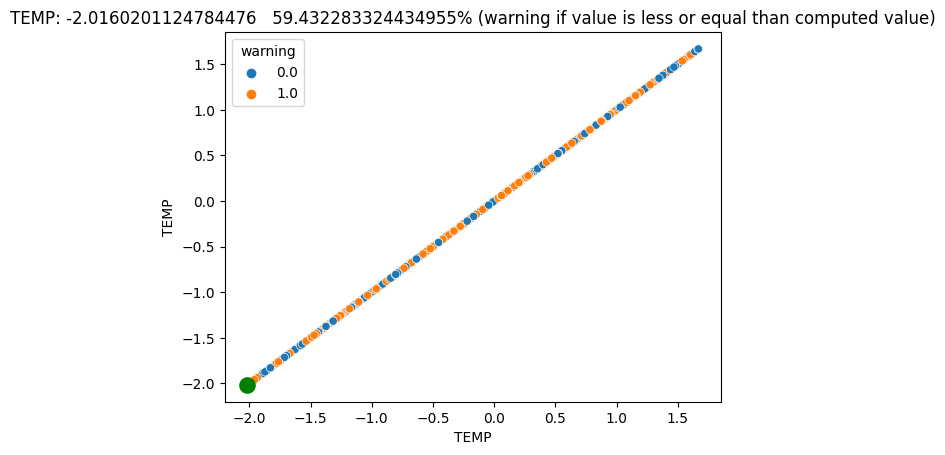

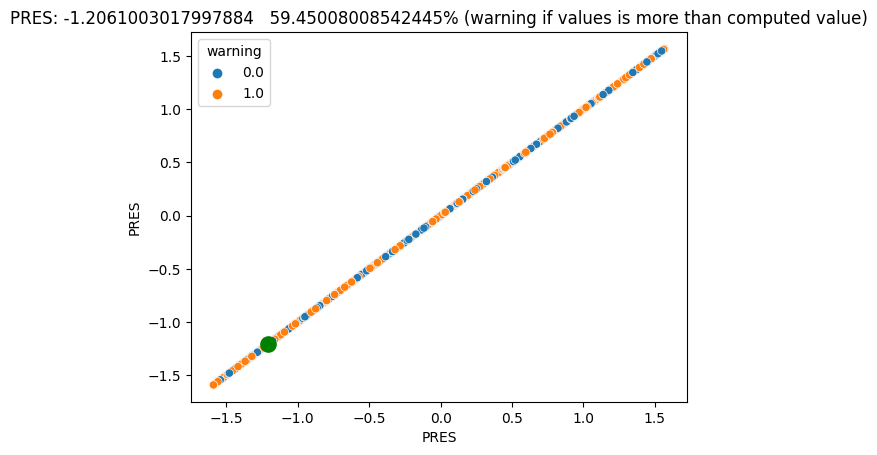

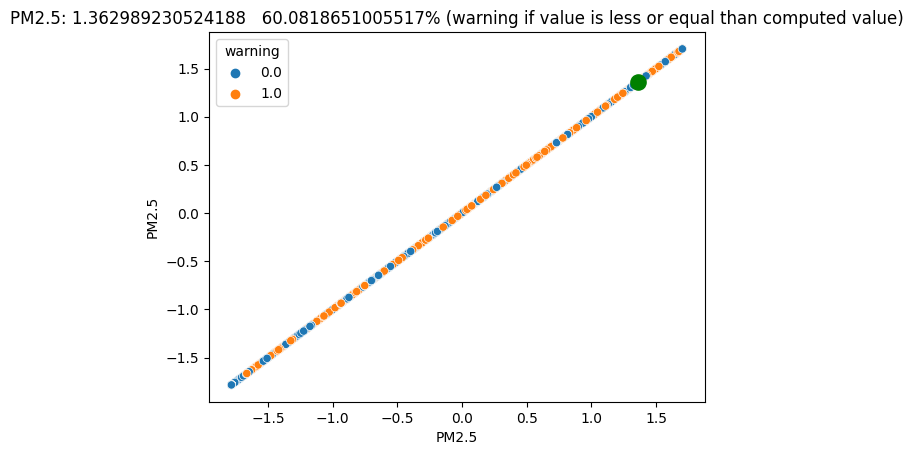

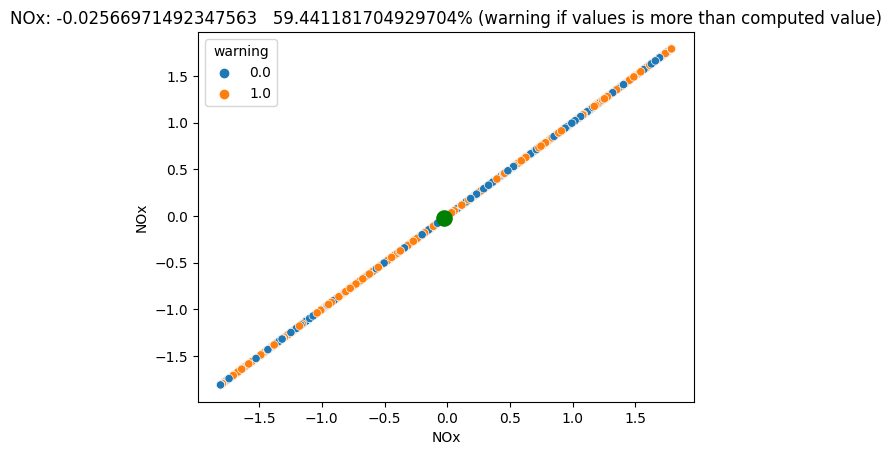

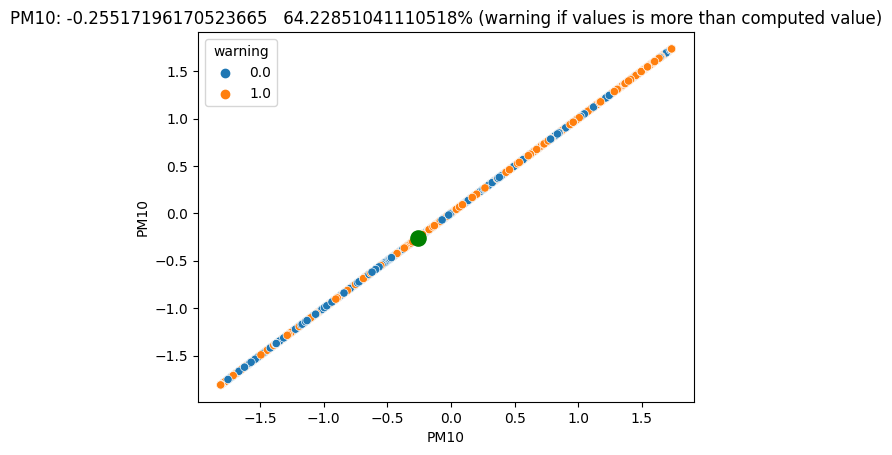

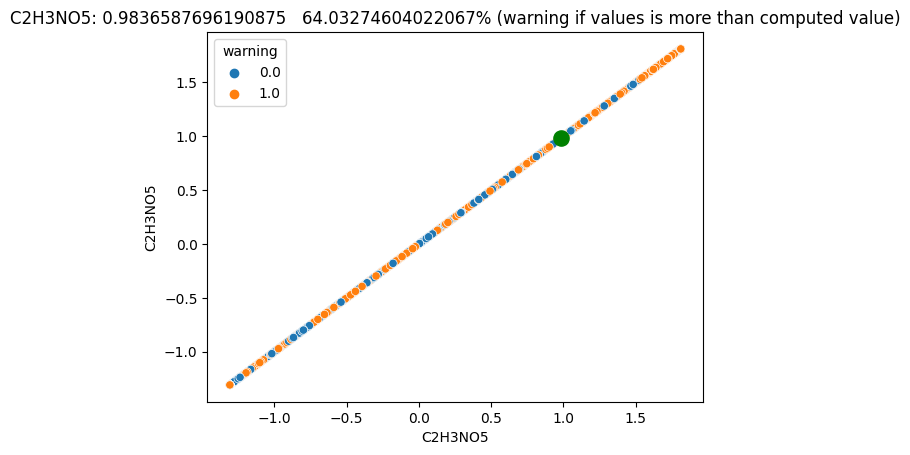

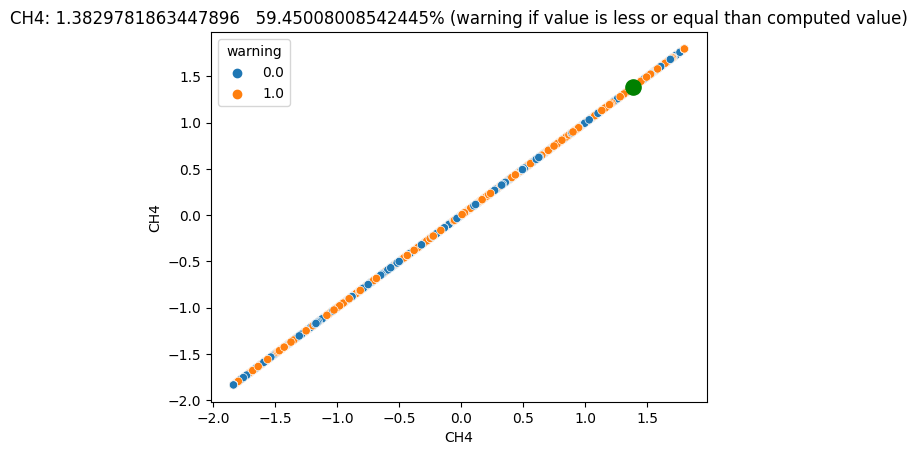

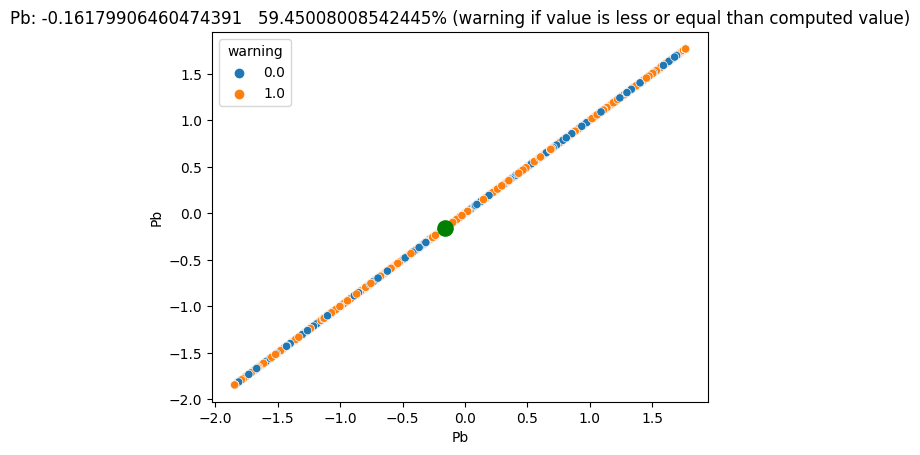

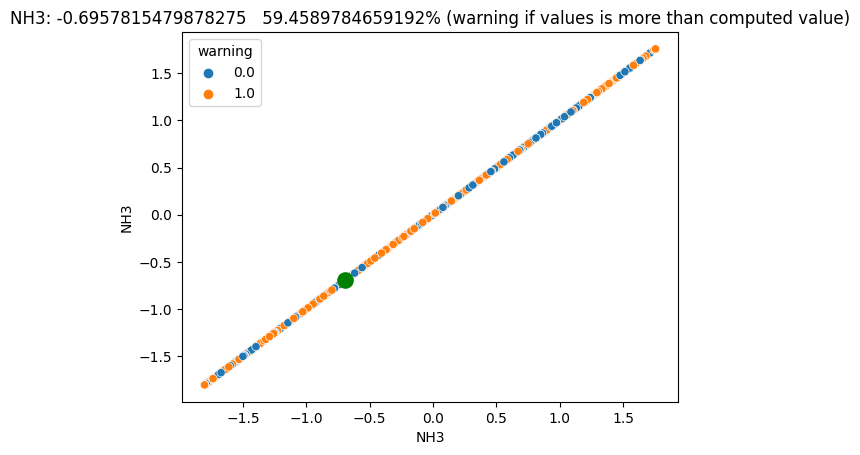

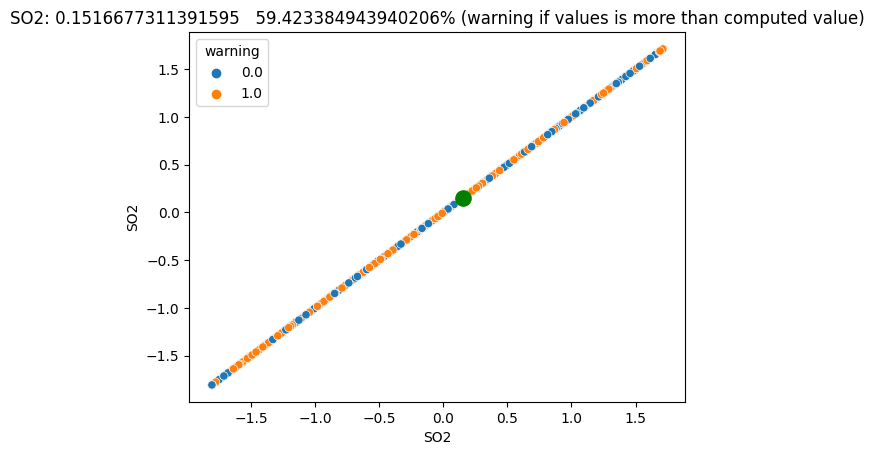

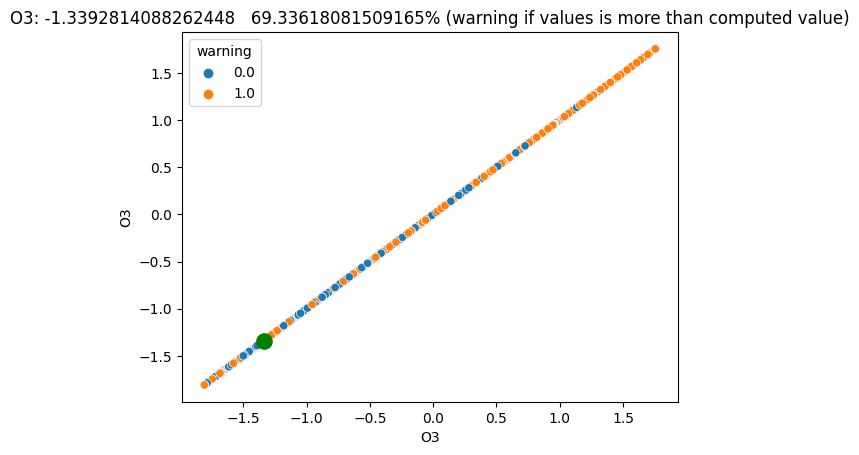

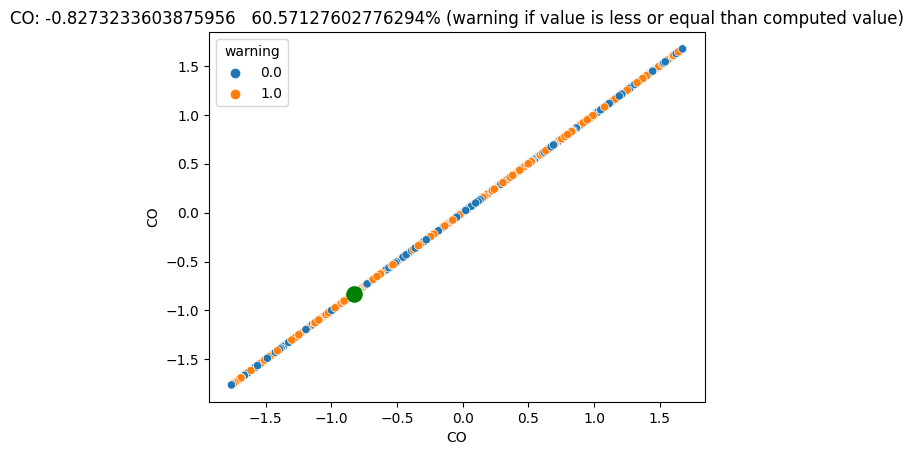

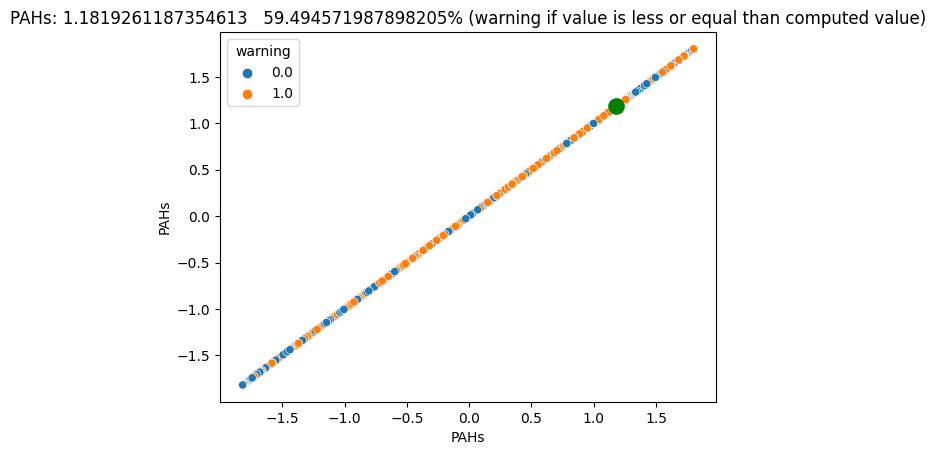

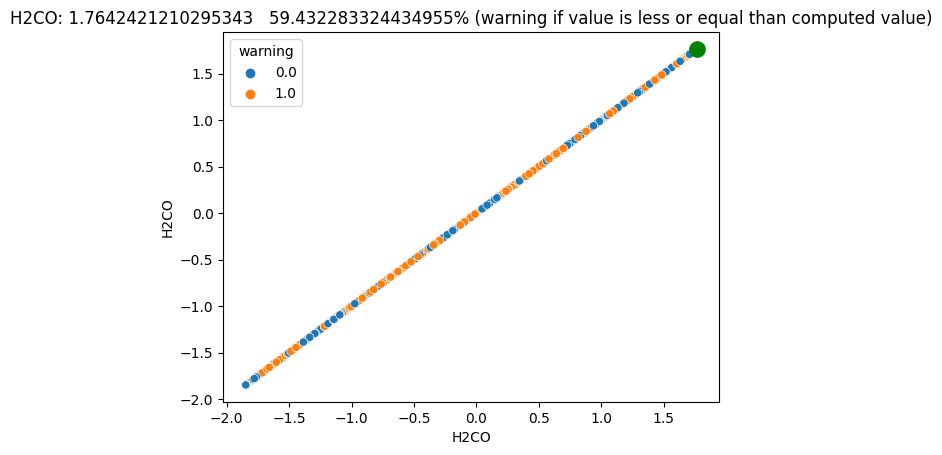

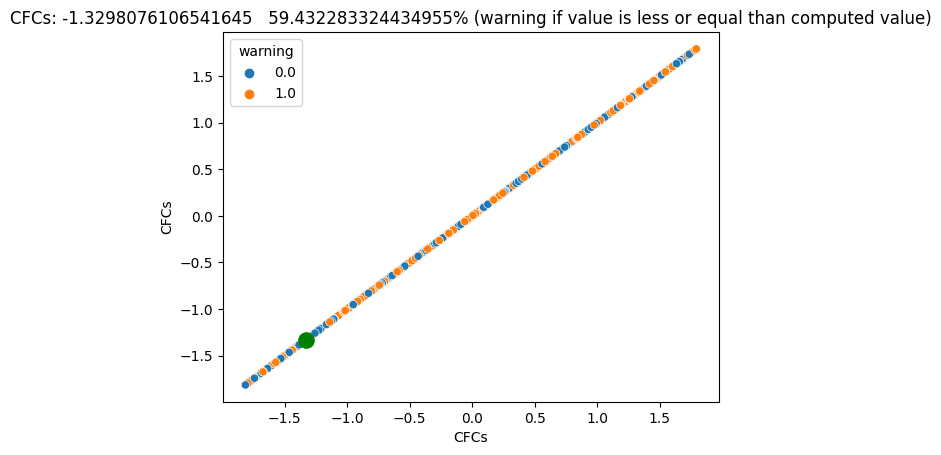

In [35]:
colnames = data.keys()
for i in range(3, len(colnames)):
    col_name, value, perc, tit = oneR_column(i, data, colnames)
    
    plt.clf()
    graf = sns.scatterplot(x=data[col_name], y=data[col_name], hue=data['warning'], sizes=(400, 400))
    graf.scatter(x=value, y=value, color='green', s=120)
    graf.set(title=tit)
    plt.show()

Výsledok ukazuje, že atribút pre klasifikovanie by mal byť O3, pri ktorom je úspešnosť klasifikácie 69.33618081509165 %. Hodnota, pri ktorej je predpokladaný warning je -1.3392814088262448 (alebo vyššia).

## 3.2. Trénovanie a vyhodnotenie klasifikátorov strojového učenia <a name="3.2."></a> 
* Na trénovanie využite minimálne jeden stromový algoritmus strojového učenia v scikit-learn.
* Vizualizujte natrénované pravidlá.
* Vyhodnoťte natrénované modely pomocou metrík accuracy, precision a recall
* Porovnajte ašpoň jeden natrénovaný klasifikátor v scikit-learn s jednoduchým klasifikátorom z prvého kroku.

[Späť na obsah](#obsah)

### 3.2.1. Decision tree <a name="3.2.1."></a> 

In [36]:
def decisionTreeDriver(X_train, X_test, y_train, y_test):
    
    cls = DecisionTreeClassifier(max_depth=None, random_state=1)
    cls.fit(X_train, y_train)
    
    predicted_train = cls.predict(X_train)
    predicted_test = cls.predict(X_test)
    
    print('Decision Tree results')
    print_results(predicted_train, predicted_test, y_train, y_test)
    
    return cls, predicted_train, predicted_test

In [37]:
clf_1, predicted_train, predicted_test = decisionTreeDriver(X_train, X_test, y_train, y_test)

Decision Tree results
Predicting for train dataset:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3008
         1.0       1.00      1.00      1.00      4521

    accuracy                           1.00      7529
   macro avg       1.00      1.00      1.00      7529
weighted avg       1.00      1.00      1.00      7529

Predicting for test dataset:
              precision    recall  f1-score   support

         0.0       0.87      0.85      0.86      1552
         1.0       0.89      0.91      0.90      2157

    accuracy                           0.88      3709
   macro avg       0.88      0.88      0.88      3709
weighted avg       0.88      0.88      0.88      3709



In [39]:
graph = Source(export_graphviz(clf_1, out_file=None, feature_names=X_train.columns, class_names = ["1","0"], filled=True, rounded=True))
graph.format = 'png'
graph.render('tree_1',view=False)
Image(filename='tree_1.png') 

### 3.2.2. Random forest <a name="3.2.2."></a> 

In [40]:
def randomForestDriver(X_train, X_test, y_train, y_test):
    
    cls = RandomForestClassifier(random_state=1, criterion='gini', max_depth=None, max_features='auto', min_samples_leaf=2, n_estimators=420)
    
    cls.fit(X_train, y_train)
    
    predicted_train = cls.predict(X_train)
    predicted_test = cls.predict(X_test)
    
    print('Random Forest results')
    print_results(predicted_train, predicted_test, y_train, y_test)
    
    return cls, predicted_train, predicted_test

In [ ]:
clf_2, train_report2, test_report2 = randomForestDriver(X_train, X_test, y_train, y_test)

In [ ]:
graph = Source(export_graphviz(clf_2.estimators_[0], out_file=None, feature_names=X_train.columns, class_names = ["1","0"], filled=True, rounded=True))
graph.format = 'png'
graph.render('tree_2',view=False)
Image(filename='tree_2.png') 

## 3.3. Optimalizácia alias hyperparameter tuning (5b) <a name="3.3."></a> 
* Preskúmajte hyperparametre Vášho zvoleného klasifikačného algoritmu v druhom kroku a vyskúšajte ich rôzne nastavenie tak, aby ste minimalizovali overfitting (preučenie) a optimalizovali výsledok. 
* Vysvetlite, čo jednotlivé hyperparametre robia. Pri nastavovaní hyperparametrov algoritmu využite krížovú validáciu (cross validation) na trénovacej množine.


[Späť na obsah](#obsah)

Klasifikačný RandomForest má celkovo 18 parametrov, z dôležitých je 7:

* max_depth
* min_sample_split
* max_leaf_nodes
* min_samples_leaf
* n_estimators
* max_sample (bootstrap sample)
* max_features

Pre zadefinovanie sme si vybrali tieto:
* max_depth: maximálna hĺbka stromu
* criterion: meranie kvality rozdelenia (gini, entropy)
* max_features: maximálny počet atribútov, ktorý je potrebné zvážiť počas každého delenia
* n_estimators: počet stromov pred priemerovaním predikcií 
* min_sample_leaf: minimálny počet vzoriek, ktoré majú pripadnúť na jeden leaf node

In [ ]:
'''params = {
    'max_depth': [5, 25, 50, 75],
    'criterion': ['gini', 'entropy'],
    'max_features': ['log2', 2, 4, 6, 8, 10],
    'min_samples_leaf': [5, 25, 50, 75],
    'n_estimators': [5, 25, 50, 75]
}'''

# neobmedzujeme počet procesorov výpočtu random_state=1
cls = RandomForestClassifier(random_state=1)

params = {
    'max_depth': [5, 10],
    'criterion': ['gini', 'entropy'],
    'max_features': ['log2', 2, 4],
    'min_samples_leaf': [5, 10],
    'n_estimators': [5, 10]
}

### 3.3.1. GridSearch Cross Validation <a name="3.3.1."></a> 

In [ ]:
gridCV = GridSearchCV(cls, params, cv=10, scoring="accuracy")

In [ ]:
gridCV.fit(X_train, y_train)

In [ ]:
gridCV.best_score_

In [ ]:
bestGrid = gridCV.best_estimator_
bestGrid

In [ ]:
gridPred_train = bestGrid.predict(X_train)
gridPred = bestGrid.predict(X_test)
print(classification_report(y_train, gridPred_train)) 
print(classification_report(y_test, gridPred)) 

### 3.3.2. RandomizedSearch Cross Validation <a name="3.3.2."></a> 

In [ ]:
randomCV = RandomizedSearchCV(cls, params, cv=7, verbose=1, n_jobs=-1, random_state=1)

In [ ]:
randomCV.fit(X_train,y_train)

In [ ]:
randomCV.best_score_

In [ ]:
bestRandom = randomCV.best_estimator_
bestRandom

In [ ]:
randomPred_train = bestRandom.predict(X_train)
randomPred = bestRandom.predict(X_test)
print(classification_report(y_train, randomPred_train)) 
print(classification_report(y_test, randomPred)) 

## 3.4. Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu (5b) <a name="3.4."></a> 

[Späť na obsah](#obsah)

Vyhodnotíte Vami zvolené stratégie riešenia projektu z hľadiska classification accuracy: 
* Stratégie riešenia chýbajúcich hodnôt a outlierov;
* Scaling resp. transformer či zlepší accuracy klasifikácie;
* Výber atribútov a výber algoritmov strojového učenia;
* Hyperparameter tuning resp. ensemble learning.
Ktoré spôsoby z hore-uvedených bodov sa ukázali ako učinné pre Váš dataset? Hodnotenie podložíte dôkazmi. 


In [ ]:
# utils
def decisionTreeDriver(X_train, X_test, y_train, y_test):
    cls = DecisionTreeClassifier(max_depth=None, random_state=1)
    cls.fit(X_train, y_train)
    predicted_train = cls.predict(X_train)
    predicted_test = cls.predict(X_test)
    return cls, predicted_train, predicted_test

def randomForestDriver(X_train, X_test, y_train, y_test):
    cls = RandomForestClassifier(random_state=1, criterion='gini', max_depth=None, max_features='auto', min_samples_leaf=2, n_estimators=420)
    cls.fit(X_train, y_train)
    predicted_train = cls.predict(X_train)
    predicted_test = cls.predict(X_test)
    return cls, predicted_train, predicted_test

### TEST 1  <a name="t1"></a> 

In [41]:
def pipelineGenerator():
    
    pipeline =  Pipeline([
        ('HandleNaNs', HandleNaNs_drop()),
        ('HandleLocation', HandleLocation()),
        ('HandleOutliers', HandleOutliers_replace()),
        ('HandleTransformations', HandleTransformations_power()),
        ('Split', Split()),
        ('handleSelection', Selection_Percentile_f_regression()),
        
    ])
    return pipeline

In [42]:
pipeline = pipelineGenerator()
X_train, X_test, y_train, y_test = pipeline.fit_transform(df_not_changed.copy())

In [43]:
clf_1, predicted_train, predicted_test = decisionTreeDriver(X_train, X_test, y_train, y_test)

Decision Tree results
Predicting for train dataset:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3034
         1.0       1.00      1.00      1.00      4495

    accuracy                           1.00      7529
   macro avg       1.00      1.00      1.00      7529
weighted avg       1.00      1.00      1.00      7529

Predicting for test dataset:
              precision    recall  f1-score   support

         0.0       0.86      0.85      0.85      1526
         1.0       0.90      0.90      0.90      2183

    accuracy                           0.88      3709
   macro avg       0.88      0.88      0.88      3709
weighted avg       0.88      0.88      0.88      3709



In [44]:
gridCV.fit(X_train, y_train)
bestGrid = gridCV.best_estimator_
gridPred_train = bestGrid.predict(X_train)
gridPred = bestGrid.predict(X_test)
print(classification_report(y_train, gridPred_train)) 
print(classification_report(y_test, gridPred)) 

NameError: name 'gridCV' is not defined

### TEST 2  <a name="t2"></a> 

In [45]:
def pipelineGenerator():
    
    pipeline =  Pipeline([
        ('HandleNaNs', HandleNaNs_median()),
        ('HandleLocation', HandleLocation()),
        ('HandleOutliers', HandleOutliers_replace()),
        ('HandleTransformations', HandleTransformations_scaleMM()),
        ('Split', Split()),
        ('handleSelection', Selection_Percentile_f_regression()),
        
    ])
    return pipeline

In [46]:
pipeline = pipelineGenerator()
X_train, X_test, y_train, y_test = pipeline.fit_transform(df_not_changed.copy())

In [47]:
clf_1, predicted_train, predicted_test = decisionTreeDriver(X_train, X_test, y_train, y_test)

Decision Tree results
Predicting for train dataset:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3207
         1.0       1.00      1.00      1.00      4759

    accuracy                           1.00      7966
   macro avg       1.00      1.00      1.00      7966
weighted avg       1.00      1.00      1.00      7966

Predicting for test dataset:
              precision    recall  f1-score   support

         0.0       0.86      0.85      0.86      1614
         1.0       0.90      0.90      0.90      2311

    accuracy                           0.88      3925
   macro avg       0.88      0.88      0.88      3925
weighted avg       0.88      0.88      0.88      3925



In [ ]:
gridCV.fit(X_train, y_train)
bestGrid = gridCV.best_estimator_
gridPred_train = bestGrid.predict(X_train)
gridPred = bestGrid.predict(X_test)
print(classification_report(y_train, gridPred_train)) 
print(classification_report(y_test, gridPred)) 

### TEST 3  <a name="t3"></a> 

In [48]:
def pipelineGenerator():
    
    pipeline =  Pipeline([
        ('HandleNaNs', HandleNaNs_knn()),
        ('HandleLocation', HandleLocation()),
        ('HandleOutliers', HandleOutliers_replace()),
        ('HandleTransformations', HandleTransformations_power()),
        ('Split', Split()),
        ('handleSelection', Selection_Percentile_f_regression()),
        
    ])
    return pipeline

In [49]:
pipeline = pipelineGenerator()
X_train, X_test, y_train, y_test = pipeline.fit_transform(df_not_changed.copy())

In [50]:
clf_2, train_report2, test_report2 = randomForestDriver(X_train, X_test, y_train, y_test)

Random Forest results
Predicting for train dataset:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      3253
         1.0       0.99      0.99      0.99      4713

    accuracy                           0.99      7966
   macro avg       0.99      0.99      0.99      7966
weighted avg       0.99      0.99      0.99      7966

Predicting for test dataset:
              precision    recall  f1-score   support

         0.0       0.95      0.90      0.92      1568
         1.0       0.94      0.97      0.95      2357

    accuracy                           0.94      3925
   macro avg       0.94      0.93      0.94      3925
weighted avg       0.94      0.94      0.94      3925



In [ ]:
gridCV.fit(X_train, y_train)
bestGrid = gridCV.best_estimator_
gridPred_train = bestGrid.predict(X_train)
gridPred = bestGrid.predict(X_test)
print(classification_report(y_train, gridPred_train)) 
print(classification_report(y_test, gridPred)) 

### TEST 4  <a name="t4"></a> 

In [51]:
def pipelineGenerator():
    
    pipeline =  Pipeline([
        ('HandleNaNs', HandleNaNs_knn()),
        ('HandleLocation', HandleLocation()),
        ('HandleOutliers', HandleOutliers_replace()),
        ('HandleTransformations', HandleTransformations_power()),
        ('Split', Split()),
        ('handleSelection', Selection_KBest_mutual_info_regression()),
        
    ])
    return pipeline

In [52]:
pipeline = pipelineGenerator()
X_train, X_test, y_train, y_test = pipeline.fit_transform(df_not_changed.copy())

In [53]:
clf_2, train_report2, test_report2 = randomForestDriver(X_train, X_test, y_train, y_test)

Random Forest results
Predicting for train dataset:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      3240
         1.0       0.99      0.99      0.99      4726

    accuracy                           0.99      7966
   macro avg       0.99      0.99      0.99      7966
weighted avg       0.99      0.99      0.99      7966

Predicting for test dataset:
              precision    recall  f1-score   support

         0.0       0.95      0.90      0.92      1581
         1.0       0.94      0.97      0.95      2344

    accuracy                           0.94      3925
   macro avg       0.94      0.93      0.94      3925
weighted avg       0.94      0.94      0.94      3925



In [ ]:
randomCV.fit(X_train,y_train)
randomPred_train = bestRandom.predict(X_train)
randomPred = bestRandom.predict(X_test)
print(classification_report(y_train, randomPred_train)) 
print(classification_report(y_test, randomPred)) 

### TEST 5  <a name="t5"></a> 

In [54]:
def pipelineGenerator():
    
    pipeline =  Pipeline([
        ('HandleNaNs', HandleNaNs_knn()),
        ('HandleLocation', HandleLocation()),
        ('HandleOutliers', HandleOutliers_replace()),
        ('HandleTransformations', HandleTransformations_power()),
        ('Split', Split()),
        ('handleSelection', Selection_KBest_mutual_info_regression()),
        
    ])
    return pipeline

In [55]:
pipeline = pipelineGenerator()
X_train, X_test, y_train, y_test = pipeline.fit_transform(df_not_changed.copy())

In [56]:
clf_2, train_report2, test_report2 = randomForestDriver(X_train, X_test, y_train, y_test)

Random Forest results
Predicting for train dataset:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      3224
         1.0       0.99      0.99      0.99      4742

    accuracy                           0.99      7966
   macro avg       0.99      0.99      0.99      7966
weighted avg       0.99      0.99      0.99      7966

Predicting for test dataset:
              precision    recall  f1-score   support

         0.0       0.95      0.89      0.92      1597
         1.0       0.93      0.97      0.95      2328

    accuracy                           0.94      3925
   macro avg       0.94      0.93      0.93      3925
weighted avg       0.94      0.94      0.94      3925



In [ ]:
randomCV.fit(X_train,y_train)
randomPred_train = bestRandom.predict(X_train)
randomPred = bestRandom.predict(X_test)
print(classification_report(y_train, randomPred_train)) 
print(classification_report(y_test, randomPred)) 

### TEST 6  <a name="t6"></a> 

In [57]:
def pipelineGenerator():
    
    pipeline =  Pipeline([
        ('HandleNaNs', HandleNaNs_knn()),
        ('HandleLocation', HandleLocation()),
        ('HandleOutliers', HandleOutliers_replace()),
        ('HandleTransformations', HandleTransformations_power()),
        ('Split', Split()),
        ('handleSelection', Selection_KBest_f_regression()),
        
    ])
    return pipeline

In [58]:
pipeline = pipelineGenerator()
X_train, X_test, y_train, y_test = pipeline.fit_transform(df_not_changed.copy())

In [59]:
clf_1, predicted_train, predicted_test = decisionTreeDriver(X_train, X_test, y_train, y_test)

Decision Tree results
Predicting for train dataset:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3257
         1.0       1.00      1.00      1.00      4709

    accuracy                           1.00      7966
   macro avg       1.00      1.00      1.00      7966
weighted avg       1.00      1.00      1.00      7966

Predicting for test dataset:
              precision    recall  f1-score   support

         0.0       0.84      0.87      0.85      1564
         1.0       0.91      0.89      0.90      2361

    accuracy                           0.88      3925
   macro avg       0.88      0.88      0.88      3925
weighted avg       0.88      0.88      0.88      3925



In [ ]:
randomCV.fit(X_train,y_train)
randomPred_train = bestRandom.predict(X_train)
randomPred = bestRandom.predict(X_test)
print(classification_report(y_train, randomPred_train)) 
print(classification_report(y_test, randomPred)) 

V jednotlivých testoch 1-6 sme vyskúšali rôzne nastavenia pre pipeline a konštatujeme, že accuracy sa výrazne nemenilo. Hodnota accuracy pre testovací dataset dosahovala hodnoty od 0,88 do 0,94 - lepšie hodnoty sme zaznamenali v testoch 1-3.

